# Text classification

In [1]:
# !wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"

In [2]:
import numpy as np
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import eli5
from collections import Counter

In [5]:
train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте

In [6]:
# @title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = ['love', 'great', 'best', 'wonderful', 'surprisingly', 'rare']  # @param {type:"raw"}
negative_words = ['worst', 'awful', '1/10', 'crap', 'terrible', 'awful', 'disgusting', 'lousy',
                  'boring', 'waste',  'disappointing', 'lame', 'dreadful', 'skip']  # @param {type:"raw"}

pos_to_add = 'excellent, fine, superior, wonderful, marvelous, qualified, suited, suitable, apt, proper, capable, '\
    'generous, kindly, friendly, gracious, obliging, pleasant, agreeable, pleasurable, satisfactory, '\
    'well-behaved, obedient, honorable, reliable, trustworthy, safe, favorable, profitable, advantageous, '\
    'righteous, expedient, helpful, valid, genuine, ample, salubrious, estimable, beneficial, splendid, '\
    'great, noble, worthy, first-rate, top-notch, grand, sterling, superb, respectable, edifying, 10/10, 9/10, '\
    'incredible, fantastic, awesome, superb, fabulous, perfect, brilliant, refreshing, wonderfully, funniest'

neg_to_add = 'evil, immoral, wicked, corrupt, sinful, depraved, rotten, contaminated, spoiled, tainted, '\
    'harmful, injurious, unfavorable, defective, inferior, imperfect, substandard, faulty, improper, '\
    'inappropriate, unsuitable, disagreeable, unpleasant, cross, nasty, unfriendly, irascible, horrible, '\
    'atrocious, outrageous, scandalous, infamous, wrong, noxious, sinister, putrid, snide, deplorable, '\
    'dismal, gross, heinous, nefarious, base, obnoxious, detestable, despicable, contemptible, '\
    'foul, rank, ghastly, execrable, aughable, fails, mess, lacks, worst, poorly, waste, disappointme'

positive_words = set(positive_words + pos_to_add.split(sep=', '))
negative_words = set(negative_words + neg_to_add.split(sep=', '))

positives_count = test_df.review.apply(
    lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(
    lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))

Test accuracy = 72.61%


*******************

In [7]:
# удаление <br /><br />
pattern = re.compile('<br />')
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

loc = 5
print(train_df['review'].loc[loc])
print()
print(pattern.subn(' ', train_df['review'].loc[loc])[0])

Wonderful film, one of the best horror films of the 70s. She is realistic settings and atmospheres. As usual it was inevitable the usual negative comments. I have noticed that most horror films of a certain period many times fail to reach even sufficiency. Obviously because most horror movies are old and must be denigrati, is like a mental mechanism that moves the minds of the potential of music critics here.  Before you read the review already knew what was the final judgment. In the film a good gift because 10 is really well done. Raines reads quite well and the film as a way in which it was produced reminds me a lot of Kubrick films. He really impression. Excellent film really. I consider a film anthology of years'70.

Wonderful film, one of the best horror films of the 70s. She is realistic settings and atmospheres. As usual it was inevitable the usual negative comments. I have noticed that most horror films of a certain period many times fail to reach even sufficiency. Obviously b

In [8]:
vectorizer = CountVectorizer()

# тест CountVectorizer
dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


In [9]:
vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])
# тест pipline
dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

model.fit(dummy_data, dummy_labels)
print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie', 'the', 'was']
[[-0.40104279  0.40104279  0.          0.          0.        ]]


In [10]:
model.fit(train_df['review'], train_df['is_positive'])

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

In [11]:
def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
eval_model(model, test_df)

Test accuracy = 86.54%


In [12]:
eli5.show_weights(classifier, vec=vectorizer, top=20)

In [13]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].loc[loc], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [14]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


In [15]:
# TfidfVectorizer
model1 = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])

model1.fit(train_df['review'], train_df['is_positive'])

eval_model(model1, test_df)

Test accuracy = 88.28%


In [16]:
# TfidfVectorizer ngram (биграммы)
model2 = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
    ('classifier', LogisticRegression())
])
model2.fit(train_df['review'], train_df['is_positive'])

eval_model(model2, test_df)

Test accuracy = 88.64%


**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [17]:
# TfidfVectorizer ngram char
model = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(2, 6), max_features=25000, analyzer='char')),
    ('classifier', LogisticRegression())
])
model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.11%


In [18]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].loc[loc], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


*****************************

# Лингвистика. Лемматизация и стемминг

**Задание** Найти формы слова с разной семантической окраской.

In [19]:
import spacy
from spacy import displacy

In [20]:
import pickle
from tqdm import tqdm
nlp = spacy.load("en_core_web_sm")

# docs_train = [doc for doc in tqdm(nlp.pipe(train_df.review.values))]
# with open('data_train.pickle', 'wb') as f:
#     pickle.dump(docs_train, f)
with open('data_train.pickle', 'rb') as f:
    docs_train = pickle.load(f)

In [21]:
# docs_test = [doc for doc in tqdm(nlp.pipe(test_df.review.values))]
# with open('data_test.pickle', 'wb') as f:
#     pickle.dump(docs_test, f)
with open('data_test.pickle', 'rb') as f:
    docs_test = pickle.load(f)    

In [23]:
token_list = []
lemma_list = []
ent_type= []
for token in docs_train[0]:
    token_list.append(token.text)
    lemma_list.append(token.lemma_)
    ent_type.append(token.ent_type_)
data_dict = {'token': token_list, 'lemma': lemma_list, 'ent_type': ent_type}

In [24]:
df_compare = pd.DataFrame(data_dict)
df_compare['predict'] = model1.predict(df_compare['token'])

In [25]:
df_result = pd.DataFrame(df_compare.groupby(by='lemma')['predict'].mean())
df_result = df_result.loc[(df_result['predict']>0) & (df_result['predict']<1)]
lemma_list = list(df_result.index)

In [26]:
df_compare.loc[df_compare['lemma'].isin(lemma_list)].sort_values(by='lemma').drop_duplicates()

,token,lemma,ent_type,predict
439,I,I,,0
402,me,I,,1
291,is,be,,1
737,Am,be,,0
407,been,be,,0
915,be,be,,0
519,are,be,,0
130,closest,close,,1
397,closing,close,,0
132,come,come,,1


**********

**Задание** Сделайте классификатор на лемматизированных текстах.

**Задание** Попробуйте вместо лемм классифицировать основы.

In [27]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import WordPunctTokenizer

lemmatizer = WordNetLemmatizer()
tokenizer = WordPunctTokenizer()
stemmer = PorterStemmer()

In [28]:
def stemmed_text(text):
    text_stem = [stemmer.stem(word) for word in tokenizer.tokenize(text)]
    return ' '.join(word for word in text_stem)
def lemma_text(text):
    text_lem = [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text)]
    return ' '.join(word for word in text_lem)

In [29]:
train_df['stemmed'] = train_df['review'].apply(stemmed_text)
test_df['stemmed'] = test_df['review'].apply(stemmed_text)
train_df['lemmatized'] = train_df['review'].apply(lemma_text)
test_df['lemmatized'] = test_df['review'].apply(lemma_text)

In [30]:
# тест лемматизации
model2.fit(train_df['lemmatized'], train_df['is_positive'])
preds = model.predict(test_df['lemmatized'])
print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))

Test accuracy = 87.15%


In [31]:
# тест стемминга
model2.fit(train_df['stemmed'], train_df['is_positive'])
preds = model.predict(test_df['stemmed'])
print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))

Test accuracy = 86.62%


*****************************

## NER

**Задание** Удалите из текстов какие-то из сущностей. Запустите классификатор.

In [32]:
stop_words = list(df_compare.loc[(df_compare['ent_type']=='PERSON') | (df_compare['ent_type']=='ORG')]['token'])
stop_words[:7]

['Tony', 'Effie', 'Jennifer', 'Hudson', 'Jamie', 'Foxx', 'Svengali']

In [33]:
# TfidfVectorizer - NER PERSON, ORG
model1 = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words)),
    ('classifier', LogisticRegression())
])

model1.fit(train_df['review'], train_df['is_positive'])

eval_model(model1, test_df)

Test accuracy = 88.28%


# NN

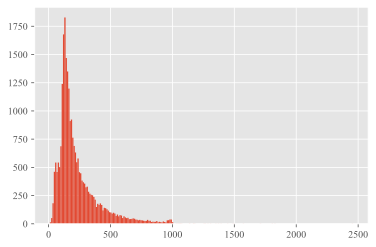

In [34]:
plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
plt.show()

In [35]:
words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
print('Words count', len(word2idx))

Words count 26783


In [36]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

In [37]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam

In [38]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=64, activation='tanh'),
    Dropout(0.25),
    Dense(units=32, activation='tanh'),
    Dropout(0.1),
    Dense(units=10, activation='tanh'),
    
    Dense(units=1, activation='sigmoid')
])
opt = Adam(learning_rate=0.001)
model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 64)          1714112   
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3

In [39]:
model.fit(X_train, train_df.is_positive, batch_size=1024, epochs=5, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/5
25/25 [==============================] - 10s 274ms/step - loss: 0.6908 - accuracy: 0.5419 - val_loss: 0.6830 - val_accuracy: 0.7892
Epoch 2/5
25/25 [==============================] - 6s 258ms/step - loss: 0.6486 - accuracy: 0.7534 - val_loss: 0.5763 - val_accuracy: 0.8211
Epoch 3/5
25/25 [==============================] - 6s 261ms/step - loss: 0.4362 - accuracy: 0.8587 - val_loss: 0.3693 - val_accuracy: 0.8451
Epoch 4/5
25/25 [==============================] - 6s 259ms/step - loss: 0.2536 - accuracy: 0.9075 - val_loss: 0.3132 - val_accuracy: 0.8686
Epoch 5/5
25/25 [==============================] - 6s 262ms/step - loss: 0.1569 - accuracy: 0.9527 - val_loss: 0.3144 - val_accuracy: 0.8723


In [40]:
model.evaluate(X_test, test_df.is_positive)

782/782 [==============================] - 8s 10ms/step - loss: 0.3144 - accuracy: 0.8723


[0.31441646814346313, 0.8722800016403198]